# Exp 2 – Linear Regression

##

### 1. Nhập các thư viện cho mô hình

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

# nhóm công cụ chia giữ liệu và đánh giá mô hình
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

# đánh giá mô hình
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import r2_score

# bỏ qua các thông báo/cảnh báo
import warnings
warnings.filterwarnings('ignore')

### 2. Tải lên file dữ liệu đã qua EDA và Preprocessing

In [2]:
train_path = "../../data/data_afterProcessed/train_processed.csv"
test_path = "../../data/data_afterProcessed/test_processed.csv"
target_path = "../../data/data_afterProcessed/target.csv"

train_processed = pd.read_csv(train_path)
test_processed = pd.read_csv(test_path)
target = pd.read_csv(target_path)

print("Đã tải các tệp dữ liệu đã qua xử lý")

Đã tải các tệp dữ liệu đã qua xử lý


### 3. Logarit hoá biến mục tiêu

In [3]:
y_log = np.log1p(target)
print("Đã log-transform SalePrice")

Đã log-transform SalePrice


##### thay đổi này giúp mô hình học nhanh hơn

### 4. Khởi tạo model với RandomizedSearchCV và Cross Validation (CV)

In [4]:
# Tạo scorer cho RMSE
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), 
                          greater_is_better=False)

##### 4.1 Tối ưu Ridge Regression

In [5]:
print("Tối ưu Ridge Regression")
param_dist_ridge = {
    'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga']
}

ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=25))
])

random_search_ridge = RandomizedSearchCV(
    ridge_pipeline, param_dist_ridge, n_iter=30, cv=5,
    scoring=rmse_scorer, n_jobs=-1, random_state=25, verbose=1
)
random_search_ridge.fit(train_processed, target.values.ravel())

print("Hoàn thành tối ưu Ridge Regression")
print(f"Các thông số tốt nhất: {random_search_ridge.best_params_}")
print(f"Điểm CV (RMSE) tốt nhất: {-random_search_ridge.best_score_:.4f}")

Tối ưu Ridge Regression
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Hoàn thành tối ưu Ridge Regression
Các thông số tốt nhất: {'ridge__solver': 'saga', 'ridge__alpha': 100}
Điểm CV (RMSE) tốt nhất: 0.1165


##### 4.2 Tối ưu Lasso Regression

In [6]:
print("Tối ưu Lasso Regression")
param_dist_lasso = {
    'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'lasso__selection': ['cyclic', 'random']
}

lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state=25, max_iter=10000))
])

random_search_lasso = RandomizedSearchCV(
    lasso_pipeline, param_dist_lasso, n_iter=20, cv=5,
    scoring=rmse_scorer, n_jobs=-1, random_state=25, verbose=1
)
random_search_lasso.fit(train_processed, target.values.ravel())

print("Hoàn thành tối ưu Lasso Regression")
print(f"Các thông số tốt nhất: {random_search_lasso.best_params_}")
print(f"Điểm CV (RMSE) tốt nhất: {-random_search_lasso.best_score_:.4f}")

Tối ưu Lasso Regression
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Hoàn thành tối ưu Lasso Regression
Các thông số tốt nhất: {'lasso__selection': 'random', 'lasso__alpha': 0.001}
Điểm CV (RMSE) tốt nhất: 0.1144


##### 4.3 Tối ưu Polynomial + Ridge Regression

In [7]:
print("Tối ưu Polynomial Features + Ridge Regression")
param_dist_poly = {
    'poly__degree': [1, 2],
    'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

poly_ridge_pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=25))
])

random_search_poly = RandomizedSearchCV(
    poly_ridge_pipeline, param_dist_poly, n_iter=20, cv=5,
    scoring=rmse_scorer, n_jobs=-1, random_state=25, verbose=1
)
random_search_poly.fit(train_processed, target.values.ravel())
print("Hoàn thành tối ưu Polynomial Ridge")
print(f"Các thông số tốt nhất: {random_search_poly.best_params_}")
print(f"Điểm CV (RMSE) tốt nhất: {-random_search_poly.best_score_:.4f}")

Tối ưu Polynomial Features + Ridge Regression
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Hoàn thành tối ưu Polynomial Ridge
Các thông số tốt nhất: {'ridge__alpha': 100, 'poly__degree': 1}
Điểm CV (RMSE) tốt nhất: 0.1165


### 5. Đánh giá mô hình và huấn luyện lần cuối với các thông số tốt nhất

In [8]:
models_comparison = {
    'Ridge': (-random_search_ridge.best_score_, random_search_ridge.best_estimator_),
    'Lasso': (-random_search_lasso.best_score_, random_search_lasso.best_estimator_),
    'Poly_Ridge': (-random_search_poly.best_score_, random_search_poly.best_estimator_)
}

best_model_name = min(models_comparison, key=lambda x: models_comparison[x][0])
best_model = models_comparison[best_model_name][1]
best_rmse = models_comparison[best_model_name][0]

print(f"{'Model':<15} {'RMSE':<10} {'Best Alpha'}")
print("-" * 40)
for name, (rmse, model) in models_comparison.items():
    if name == 'Poly_Ridge':
        alpha = model.named_steps['ridge'].alpha
        degree = model.named_steps['poly'].degree
        print(f"{name:<15} {rmse:<10.4f} alpha={alpha}, degree={degree}")
    else:
        alpha = model.named_steps[ name.lower() ].alpha
        print(f"{name:<15} {rmse:<10.4f} alpha={alpha}")

print(f"Mô hình tốt nhất: {best_model_name} (RMSE: {best_rmse:.4f})")


Model           RMSE       Best Alpha
----------------------------------------
Ridge           0.1165     alpha=100
Lasso           0.1144     alpha=0.001
Poly_Ridge      0.1165     alpha=100, degree=1
Mô hình tốt nhất: Lasso (RMSE: 0.1144)


##### Lấy ra mô hình tốt nhất để huấn luyện 

In [9]:
# Cuối cùng ta huấn luyện mô hình Lasso vì có kết quả tốt nhất
model_LR = best_model
model_LR.fit(train_processed, target.values.ravel())
print(f"Đã huấn luyện xong mô hình {best_model_name}")

Đã huấn luyện xong mô hình Lasso


### 6. Đánh giá về điểm và độ ổn định của các Fold

In [10]:
# Dự đoán trên tập train
y_pred_train = model_LR.predict(train_processed)

# R² score trên giá trị gốc
r2_original = r2_score(target, y_pred_train)

# Chuyển sang log scale để đánh giá
y_pred_log = np.log1p(y_pred_train)
rmse_log = np.sqrt(mean_squared_error(y_log, y_pred_log))
r2_log = r2_score(y_log, y_pred_log)

print(f"RMSE (log scale): {rmse_log:.4f}")
print(f"R² (log scale): {r2_log:.4f}")
print(f"R² trên tập train: {r2_original:.4f}")

RMSE (log scale): 0.0076
R² (log scale): 0.9366
R² trên tập train: 0.9385


In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=25)

cv_scores_optimized = cross_val_score(
    model_LR, 
    train_processed, 
    target.values.ravel(), 
    cv=kf, 
    scoring=rmse_scorer,
    n_jobs=-1
)
cv_scores_optimized = -cv_scores_optimized

print("Điểm RMSE của từng Fold: ")
for i, score in enumerate(cv_scores_optimized, 1):
    print(f"Fold {i}: RMSE = {score:.4f}")

print(f"RMSE trung bình: {cv_scores_optimized.mean():.4f} (+/- {cv_scores_optimized.std() * 2:.4f})")

Điểm RMSE của từng Fold: 
Fold 1: RMSE = 0.1169
Fold 2: RMSE = 0.1187
Fold 3: RMSE = 0.1115
Fold 4: RMSE = 0.1111
Fold 5: RMSE = 0.1200
RMSE trung bình: 0.1156 (+/- 0.0073)


In [12]:
# Độ ổn định của mô hình 
print(f"RMSE nhỏ nhất: {cv_scores_optimized.min():.4f}")
print(f"RMSE lớn nhất: {cv_scores_optimized.max():.4f}")
print(f"Khoảng biến động: {cv_scores_optimized.max() - cv_scores_optimized.min():.4f}")

if cv_scores_optimized.std() < cv_scores_optimized.mean() * 0.1:
    print("Mô hình tương đối ổn định qua các fold")
else:
    print("Mô hình có độ biến động lớn qua các fold")

RMSE nhỏ nhất: 0.1111
RMSE lớn nhất: 0.1200
Khoảng biến động: 0.0088
Mô hình tương đối ổn định qua các fold


### 7. Tạo file submit bài và lưu file mô hình

In [13]:
test_pred_optimized = model_LR.predict(test_processed)

if test_pred_optimized.ndim > 1:
    test_pred_optimized = test_pred_optimized.ravel()

test_pred_final = np.expm1(test_pred_optimized)

# Tạo submission file
submission_optimized = pd.DataFrame({
    'Id': range(1461, 1461 + len(test_pred_final)),  
    'SalePrice': test_pred_final
})

submission_optimized.to_csv('result/LR_submission.csv', index=False)
print("Đã tạo file LR_submission.csv")

Đã tạo file LR_submission.csv


In [14]:
joblib.dump(model_LR, 'pkl/Linear_model.pkl')
print("Đã lưu mô hình Linear Regression")

Đã lưu mô hình Linear Regression


### 8. Biểu đồ các đặc trưng quan trọng nhất của mô hình

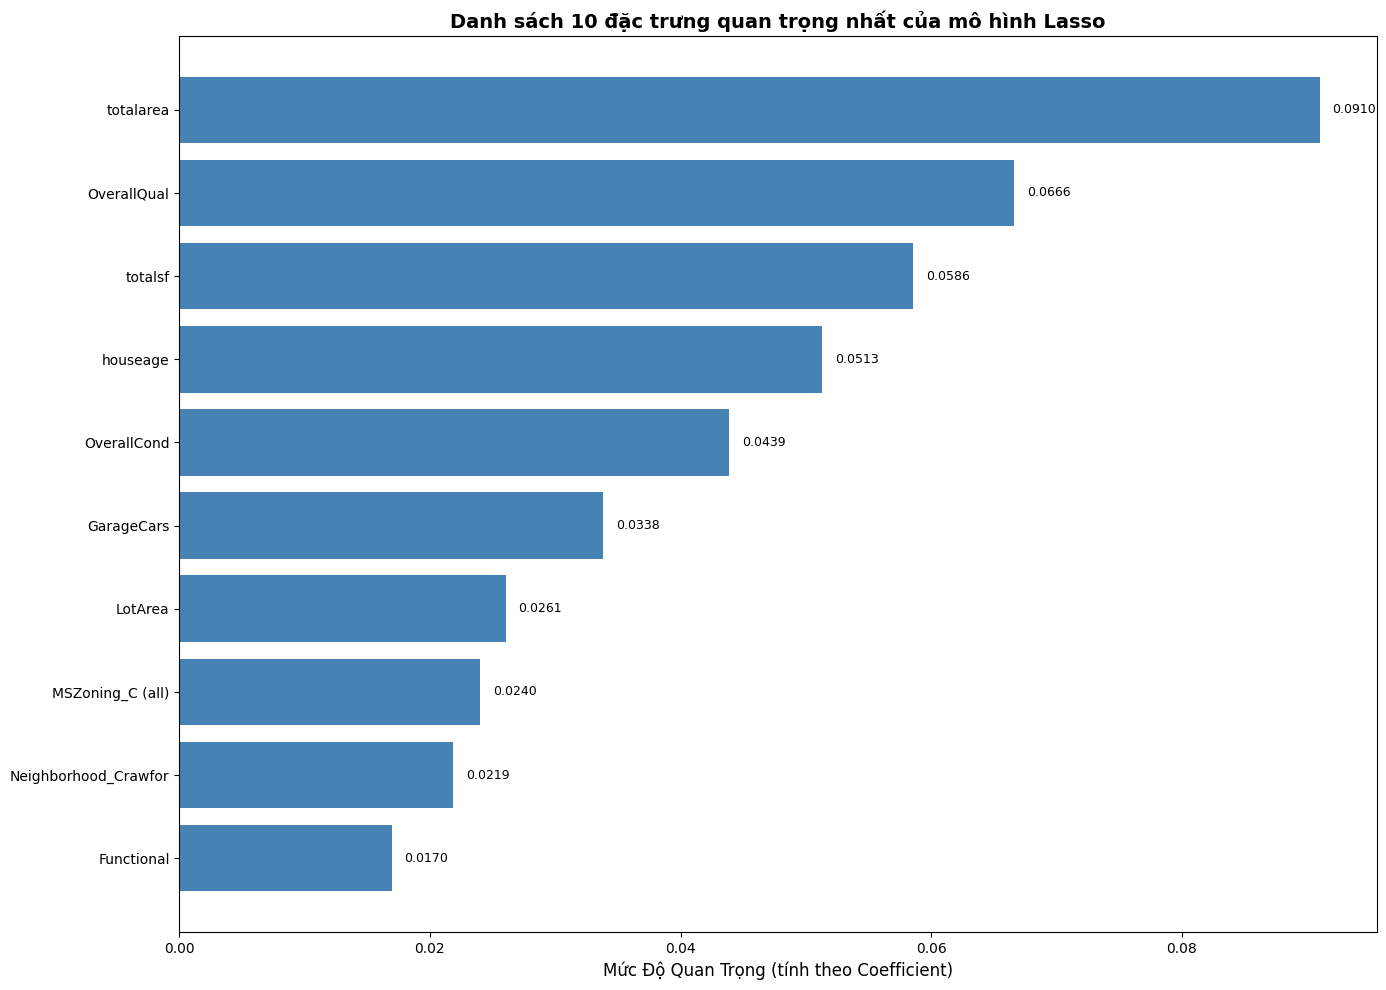

In [15]:
# Lấy model cuối cùng từ pipeline
if best_model_name == 'Ridge':
    final_model = model_LR.named_steps['ridge']
    scaler = model_LR.named_steps['scaler']
elif best_model_name == 'Lasso':
    final_model = model_LR.named_steps['lasso']
    scaler = model_LR.named_steps['scaler']
else:  # Poly_Ridge
    final_model = model_LR.named_steps['ridge']
    scaler = model_LR.named_steps['scaler']
    poly = model_LR.named_steps['poly']

# Lấy coefficients
if best_model_name == 'Poly_Ridge':
    # Với Polynomial, số feature sẽ nhiều hơn
    coefficients = final_model.coef_
    feature_names = poly.get_feature_names_out(train_processed.columns)
else:
    coefficients = final_model.coef_
    feature_names = train_processed.columns

# Tạo DataFrame feature importance
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'importance': np.abs(coefficients)
}).sort_values('importance', ascending=False)

# 10 đặc trưng quan trọng nhất
top_10_features = feature_importance.head(10)
top_10_features_display = top_10_features.iloc[::-1]

# Vẽ biểu đồ 
plt.figure(figsize=(14, 10))
bars = plt.barh(
    top_10_features_display['feature'], 
    top_10_features_display['importance'],
    color='steelblue'
)
plt.title(f'Danh sách 10 đặc trưng quan trọng nhất của mô hình {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('Mức Độ Quan Trọng (tính theo Coefficient)', fontsize=12)

# Thêm giá trị trên mỗi cột
for bar, importance in zip(bars, top_10_features_display['importance']):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{importance:.4f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()